In [1]:
import pandas as pd

# Load your datasets
approx_entropy_df = pd.read_csv('Combined_Entropy.csv')
entropy_per_channel_df = pd.read_csv('eeg_entropy_features.csv')
frequency_features_df = pd.read_csv('eeg_frequency_features.csv')

# Merge all datasets on Patient_ID
combined_data = approx_entropy_df.merge(entropy_per_channel_df, on="Patient_ID",how='left')
combined_data = combined_data.merge(frequency_features_df, on="Patient_ID",how='left')

# Merge with suffixes to keep track of Label columns
combined_data = approx_entropy_df.merge(entropy_per_channel_df, on="Patient_ID", how='left', suffixes=('', '_entropy'))
combined_data = combined_data.merge(frequency_features_df, on="Patient_ID", how='left', suffixes=('', '_frequency'))

# Check if 'Label_entropy' and 'Label_frequency' columns are identical to 'Label'
if 'Label_entropy' in combined_data.columns and (combined_data['Label'] == combined_data['Label_entropy']).all():
    combined_data = combined_data.drop(columns=['Label_entropy'])
if 'Label_frequency' in combined_data.columns and (combined_data['Label'] == combined_data['Label_frequency']).all():
    combined_data = combined_data.drop(columns=['Label_frequency'])

print(combined_data.head(1))
print(combined_data.shape)
print(combined_data['Label'].value_counts())



    Patient_ID  Label       Fp1       Fp2        F3        F4        C3  \
0  v1p_v1p.csv      1  1.642273  1.399319  1.788776  1.385568  1.894291   

         C4        P3        P4  ...  occipital_theta_avg_power  \
0  1.719796  1.915635  1.512754  ...                 556.439793   

   occipital_alpha_avg_power  occipital_beta_avg_power  \
0                 417.316758                589.752563   

   occipital_gamma_avg_power  temporal_delta_avg_power  \
0                 195.140531                  879.2552   

   temporal_theta_avg_power  temporal_alpha_avg_power  \
0                580.225853                478.095124   

   temporal_beta_avg_power  temporal_gamma_avg_power  \
0               480.728786                 232.60505   

   frontal_parietal_theta_ratio  
0                      0.983045  

[1 rows x 240 columns]
(121, 240)
Label
1    61
0    60
Name: count, dtype: int64


In [2]:
# Separate features and target label
X = combined_data.drop(columns=["Patient_ID", "Label"])
y = combined_data["Label"]


In [3]:
from sklearn.model_selection import train_test_split

# Split data into training and testing sets (80% train, 20% test)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [4]:
from xgboost import XGBClassifier
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score

# Initialize the XGBoost classifier
xgb_model = XGBClassifier(random_state=42, use_label_encoder=False, eval_metric='logloss')

# Fit the model to the training data
xgb_model.fit(X_train, y_train)

# Make predictions on the test set
y_pred = xgb_model.predict(X_test)

# Evaluate the model
accuracy = accuracy_score(y_test, y_pred)
print(f"Accuracy: {accuracy:.2f}")

print("Classification Report:\n", classification_report(y_test, y_pred))
print("Confusion Matrix:\n", confusion_matrix(y_test, y_pred))


Accuracy: 0.84
Classification Report:
               precision    recall  f1-score   support

           0       0.93      0.81      0.87        16
           1       0.73      0.89      0.80         9

    accuracy                           0.84        25
   macro avg       0.83      0.85      0.83        25
weighted avg       0.86      0.84      0.84        25

Confusion Matrix:
 [[13  3]
 [ 1  8]]


In [5]:
from sklearn.model_selection import GridSearchCV
from xgboost import XGBClassifier

# Define the parameter grid
param_grid = {
    'n_estimators': [50, 100, 200],               # Number of boosting rounds
    'max_depth': [3, 5, 7],                       # Maximum depth of a tree
    'learning_rate': [0.01, 0.1, 0.2],            # Step size shrinkage
    'subsample': [0.8, 1.0],                      # Subsample ratio of the training data
    'colsample_bytree': [0.8, 1.0],               # Subsample ratio of columns
    'gamma': [0, 0.1, 0.2]                        # Minimum loss reduction required for partitioning
}

# Initialize the XGBoost model
xgb = XGBClassifier(random_state=42, use_label_encoder=False, eval_metric='logloss')

# Set up GridSearchCV
grid_search = GridSearchCV(estimator=xgb, param_grid=param_grid, scoring='accuracy', 
                           cv=5, verbose=1, n_jobs=-1)

# Fit GridSearchCV to find the best hyperparameters
grid_search.fit(X_train, y_train)

# Retrieve the best model and parameters
best_xgb = grid_search.best_estimator_
best_params = grid_search.best_params_

print("Best Parameters:", best_params)



Fitting 5 folds for each of 324 candidates, totalling 1620 fits


Best Parameters: {'colsample_bytree': 0.8, 'gamma': 0, 'learning_rate': 0.1, 'max_depth': 5, 'n_estimators': 50, 'subsample': 0.8}


In [6]:
# Make predictions with the best model
y_pred_best = best_xgb.predict(X_test)

# Evaluate the tuned model
from sklearn.metrics import classification_report, accuracy_score, confusion_matrix
accuracy = accuracy_score(y_test, y_pred_best)
print(f"Accuracy after tuning: {accuracy:.2f}")
print("Classification Report:\n", classification_report(y_test, y_pred_best))
print("Confusion Matrix:\n", confusion_matrix(y_test, y_pred_best))


Accuracy after tuning: 0.88
Classification Report:
               precision    recall  f1-score   support

           0       0.93      0.88      0.90        16
           1       0.80      0.89      0.84         9

    accuracy                           0.88        25
   macro avg       0.87      0.88      0.87        25
weighted avg       0.89      0.88      0.88        25

Confusion Matrix:
 [[14  2]
 [ 1  8]]


c:\Users\smrit\miniconda3\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
PermutationExplainer explainer: 26it [00:14,  2.43s/it]                        



SHAP Summary Plot for Class 0 (Control)


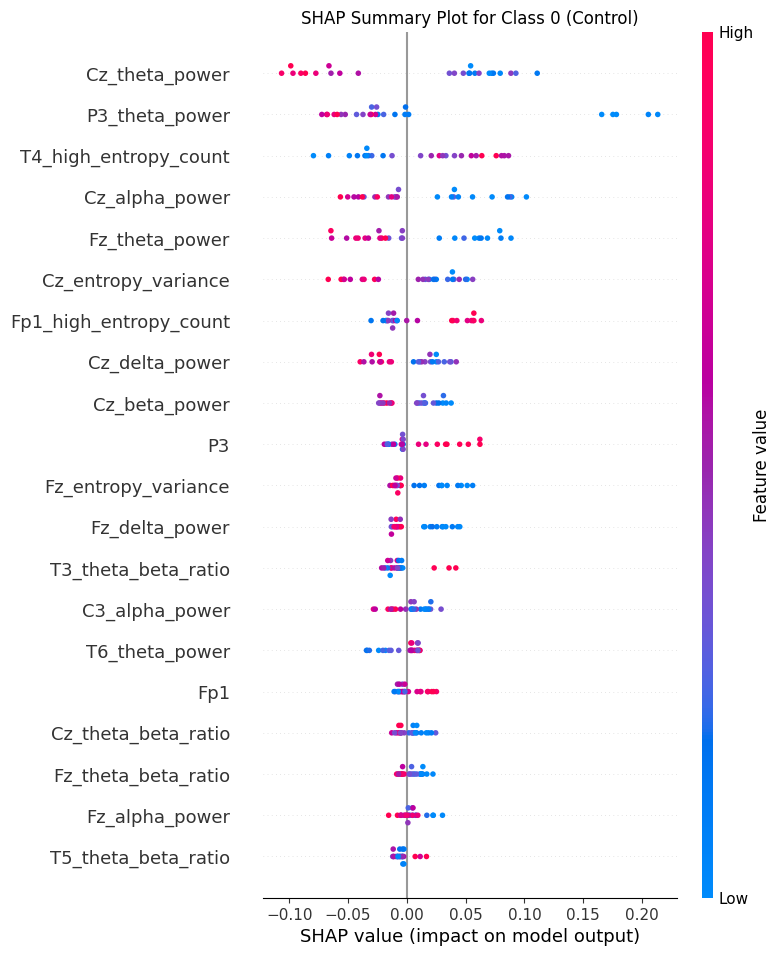


SHAP Summary Plot for Class 1 (ADHD)


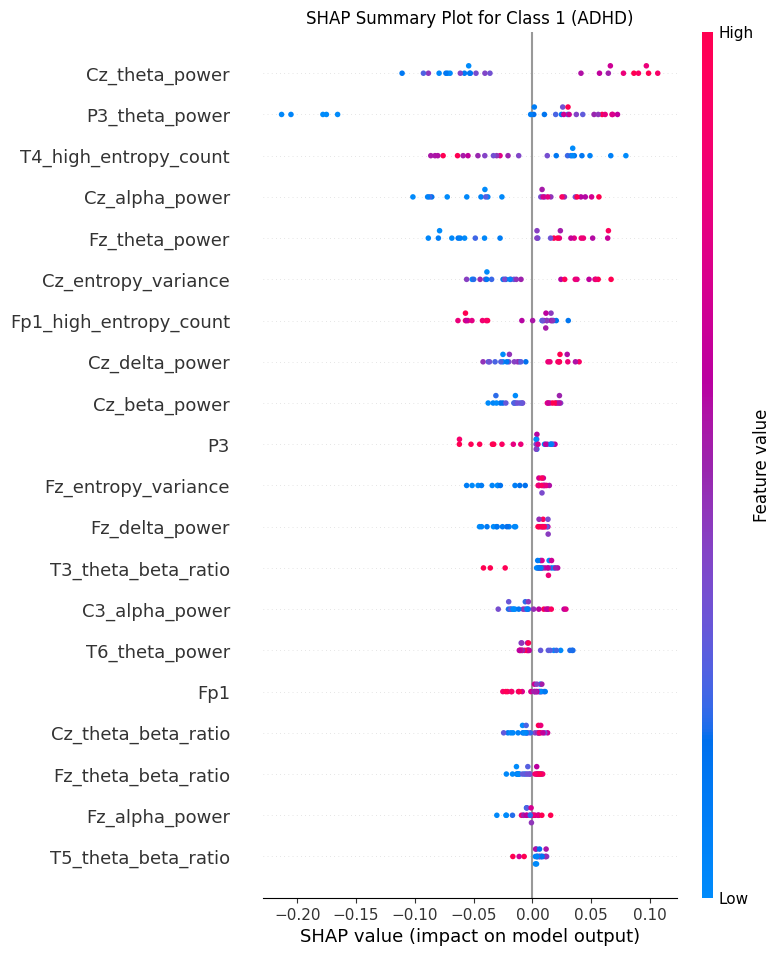

In [7]:
import shap
import matplotlib.pyplot as plt
feature_names = X_train.columns.tolist()  # Get feature names from the training set
target_names = ['Control', 'ADHD']  # Modify these names based on your dataset's labels

# Initialize SHAP explainer for a binary classification model
explainer = shap.Explainer(best_xgb.predict_proba, X_train)
shap_values = explainer(X_test)

# Loop through both classes (binary classification)
for class_label in range(2):
    print(f"\nSHAP Summary Plot for Class {class_label} ({target_names[class_label]})")

    # Extract SHAP values for the specific class
    class_shap_values = shap_values.values[:, :, class_label]
    
    # Plot SHAP summary for this class
    shap.summary_plot(class_shap_values, X_test,
                      feature_names=feature_names, show=False)
    plt.title(f"SHAP Summary Plot for Class {class_label} ({target_names[class_label]})")
    plt.show()


c:\Users\smrit\miniconda3\Lib\site-packages\lime\discretize.py:110: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  ret[feature] = int(self.lambdas[feature](ret[feature]))
c:\Users\smrit\miniconda3\Lib\site-packages\lime\discretize.py:110: FutureWarning: Series.__setitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To set a value by position, use `ser.iloc[pos] = value`
  ret[feature] = int(self.lambdas[feature](ret[feature]))
c:\Users\smrit\miniconda3\Lib\site-packages\lime\lime_tabular.py:544: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by positio

Explanation for Instance: 0
Predicted Class: 0
Probability of Predicted Class: 0.5946647
Local Feature Importance:
P3_theta_power <= 498.71: -0.2585546582069513
Fz_theta_power <= 537.39: -0.10959096617526794
Cz_theta_power <= 64.69: -0.10737004815287852
Cz_alpha_power <= 33.77: -0.09516847914387845
T4_high_entropy_count <= 3919.25: 0.09467878648414998
Cz_beta_power <= 42.84: -0.05612549646416843
Cz_entropy_variance <= 342.26: -0.05415644240051929
Fz_entropy_variance <= 2480.50: -0.050911368882134704
Fz_delta_power <= 853.01: -0.04915278485927692
Fp1_high_entropy_count <= 3902.50: 0.03930372950535257


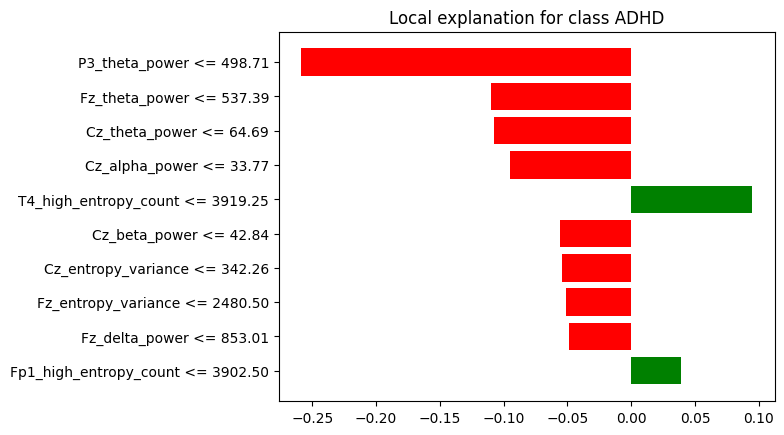

In [8]:
import lime
import lime.lime_tabular
import numpy as np

# Initialize the LIME explainer
explainer = lime.lime_tabular.LimeTabularExplainer(
    training_data=np.array(X_train),
    feature_names=X_train.columns,
    class_names=['Control', 'ADHD'],  # Adjust based on your label names
    mode='classification'
)
instance_index = 0
instance = X_test.iloc[instance_index]

# Choose a test instance to explain
exp = explainer.explain_instance(X_test.iloc[instance_index], best_xgb.predict_proba, num_features=10)


exp.show_in_notebook(show_table=True)

print("Explanation for Instance:", instance_index)
print("Predicted Class:", best_xgb.predict([instance])[0])
print("Probability of Predicted Class:", np.max(best_xgb.predict_proba([instance])))
print("Local Feature Importance:")

for feature_name, weight in exp.as_list():
  print(f"{feature_name}: {weight}")
import matplotlib.pyplot as plt

# Customize the plot's background color
fig = exp.as_pyplot_figure()
fig.patch.set_facecolor('white')  # Change the background color to white

# Show the plot
plt.show()


